## How To Get Couchbase Performance Metrics With Python

### Part 1: Collecting Couchbase metrics from the Couchbase API

### Introduction

Couchbase provides an administration console with graphs of performance metrics as well as a [REST](https://developer.couchbase.com/documentation/server/3.x/admin/REST/rest-bucket-stats.html) interface. The graphs are useful for quick analysis, but the console lacks the ability to view metrics graphed over each other and give no way of exporting the raw data.

This article shows how to retrieve metric data from the REST api and examples of how to plot the data for deeper analysis and visualization.  It includes a python class that can be imported and used to simplify the data extraction process.

### Quick Starter on getting Couchbase metrics 

The Clicker class abstracts the REST call to retrieve bucket data.  Use it as an example of how to extract bucket statistics from the Couchbase REST API or import it directly into your python code and use it.

In [1]:
!pip install pandas numpy matplotlib

In [2]:
# %load clicker.py
import requests
import numpy
import datetime
import time
import csv
import json
import logging

logging.basicConfig(format="%(asctime)s - %(thread)s - %(levelname)s - %(message)s")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

class Clicker:
    """ gets stuff from the couch """
    def __init__(self, event):
        if 'debug' in event and event['debug'] == True:
            self._set_logger(logging.DEBUG)
        self.event = event
        self.host = event['host']
        self.bucket = event['bucket']
        self.zoom = event['zoom']
        self.metrics = event['metrics']
        self.creds = event['creds']
        self.session = self.get_session()
        self.uri = self.geturi()
        logger.debug(event)

    def _set_logger(self, level=logging.INFO):
        logger.setLevel(level)

    def get_session(self):
        session = requests.Session()
        return session

    def geturi(self):
        url = "http://{host}:8091/pools/default/buckets/{bucket}/stats?zoom={zoom}".format(host=self.host,
                                                                                           bucket=self.bucket,
                                                                                           zoom=self.zoom)
        return url

    def getraw(self):
        raw_data = self.session.get("%s" % (self.uri), auth=(self.creds[0], self.creds[1])).json()
        return raw_data

    def getdata(self):
        data = self.getraw()
        return_data = []
        ts = data['op']['samples']['timestamp']
        for metric in self.metrics:
            if metric in data['op']['samples']:
                dataset = data['op']['samples'][metric]
                if 'mem' in metric or 'disk_size' in metric:
                    dataset[:] = [int(x / (1024 * 1024)) for x in metrics]
                return_data.append(dataset)
            else:
                return False
        return ts, return_data

## Imports

In [10]:
import clicker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

## Input

In [4]:
event = {
    'host':'10.10.10.60',
    'bucket': 'NeonCache',
    'zoom': 'day',
    'metrics': ['cmd_set','cmd_get','cpu_utilization_rate'],
    'creds' : ['readonly', 'xxxxxxxxxxxx']
    }

## Get Data

In [5]:
def get_metrics(event):
    c = clicker.Clicker(event)
    dt, metrics = c.getdata()
    return dt, metrics

raw_dt, metrics = get_metrics(event) 

## Transform Data

prepare the date array for plotting

In [6]:
def fix_dates(data):
    fixed=[]
    for dt in data:
        fixed.append( long(str(dt/1000)) ) 
    return mdates.epoch2num(fixed)

dt=fix_dates(raw_dt)

convert unix timestamp to something human readable. 

In [7]:
def convert_dt(dt):    
    return(datetime.datetime.fromtimestamp(int(dt)/1000).strftime('%Y-%m-%d %H:%M:%S'))

map(convert_dt, raw_dt)[0:5]

['2018-07-31 10:46:00',
 '2018-07-31 10:47:00',
 '2018-07-31 10:48:00',
 '2018-07-31 10:49:00',
 '2018-07-31 10:50:00']

## Model the data

Use pandas to create a dataframe to view the data as a table.

In [8]:
str_dt = map(convert_dt, raw_dt)

def tabulate_data(top):
    df=pd.DataFrame(metrics, columns= str_dt)
    row_names = {}
    for idx, metric in enumerate(event['metrics']):
        row_names[idx] = metric
    df.rename(index=row_names, inplace=True)
    return df.transpose()[0:top]

tabulate_data(top=15)

,cmd_set,cmd_get,cpu_utilization_rate
2018-07-31 10:46:00,0.103617,17.285467,24.397350
2018-07-31 10:47:00,12.328989,39.137398,22.743569
2018-07-31 10:48:00,0.142857,15.207308,23.636377
2018-07-31 10:49:00,0.249964,18.573173,15.260794
2018-07-31 10:50:00,0.192346,18.763770,16.698813
2018-07-31 10:51:00,0.388060,18.669139,14.956505
2018-07-31 10:52:00,0.382686,14.997750,20.656938
2018-07-31 10:53:00,0.285714,15.270525,16.847460
2018-07-31 10:54:00,0.142929,18.580411,14.216631
2018-07-31 10:55:00,0.178643,19.545286,16.937439


## Visualization

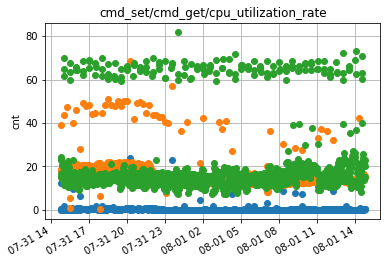

In [9]:
def plot(dt,data, fmt):
    for m in data:
        plt.plot_date(x=dt, y=m, fmt=fmt)
    plt.title('/'.join(event['metrics']))
    plt.ylabel('cnt')
    plt.grid(True)
    fig = plt.figure(1)
    fig.autofmt_xdate()
    plt.show()
 
plot(dt,metrics,fmt='o')